In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting
import os
from cvxpy import ECOS, OSQP, SCS

In [2]:

# Loading predictions & historical returns

preds = pd.read_csv("C:\\Users\\ansul\\OneDrive\\Desktop\\data science project\\portfolio_optimization_ML\\data\\processed\\predicted_probabilities.csv", parse_dates=["Date"])
returns = pd.read_csv("C:\\Users\\ansul\\OneDrive\\Desktop\\data science project\\portfolio_optimization_ML\\data\\processed\\daily_returns.csv", parse_dates=["Date"], index_col="Date")

print("Predictions sample:")
print(preds.head())

print("Returns sample:")
print(returns.head())


Predictions sample:
        Date  Pred_Prob_Up  True_Label Ticker
0 2024-02-29      0.524484           0   AAPL
1 2024-02-29      0.525042           1   MSFT
2 2024-02-29      0.525421           1   TSLA
3 2024-02-29      0.525758           1   AMZN
4 2024-02-29      0.525758           0    JPM
Returns sample:
                AAPL      MSFT      AMZN      TSLA       JPM
Date                                                        
2018-01-03 -0.000174  0.004654  0.012775 -0.010233  0.001019
2018-01-04  0.004645  0.008801  0.004476 -0.008290  0.014326
2018-01-05  0.011385  0.012398  0.016163  0.006230 -0.006420
2018-01-08 -0.003715  0.001020  0.014425  0.062638  0.001477
2018-01-09 -0.000115 -0.000679  0.004676 -0.008085  0.005069


In [15]:
# Converting predicted probability → expected return

avg_returns_by_ticker = returns.mean()
preds = preds.merge(avg_returns_by_ticker.rename("Avg_Return"), left_on="Ticker", right_index=True)
preds["Expected_Return"] = preds["Pred_Prob_Up"] * preds["Avg_Return"]

# Last predicted return per ticker (latest day in dataset)
mu_ml = preds.groupby("Ticker")["Expected_Return"].last()

print("\nPredicted Expected Returns (latest):")
print(mu_ml)


Predicted Expected Returns (latest):
Ticker
AAPL    0.000586
AMZN    0.000488
JPM     0.000426
MSFT    0.000590
TSLA    0.001178
Name: Expected_Return, dtype: float64


In [16]:
# estimate expected returns and sample covariance
mu_hist = expected_returns.mean_historical_return(returns)  # classical expected returns
S = risk_models.sample_cov(returns)

c:\Users\ansul\AppData\Local\Programs\Python\Python312\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
c:\Users\ansul\AppData\Local\Programs\Python\Python312\Lib\site-packages\pypfopt\expected_returns.py:36: UserWarning: Some returns are infinite. Please check your price data.
  warnings.warn(
c:\Users\ansul\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:57: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


In [17]:
# Fix NaNs in mu_hist by filling with avg_daily_return
mu_hist_fixed = mu_hist.fillna(avg_daily_return)

# Buildig classical portfolio
ef_classical = EfficientFrontier(mu_hist_fixed, S)
weights_classical = ef_classical.max_sharpe()
cleaned_weights_classical = ef_classical.clean_weights()
performance_classical = ef_classical.portfolio_performance(verbose=True)

# Building ML-driven portfolio
ef_ml = EfficientFrontier(mu_ml, S)
weights_ml = ef_ml.max_sharpe()
cleaned_weights_ml = ef_ml.clean_weights()
performance_ml = ef_ml.portfolio_performance(verbose=True)

Expected annual return: 0.1%
Annual volatility: 15024.5%
Sharpe Ratio: 0.00
Expected annual return: 0.1%
Annual volatility: 16102.1%
Sharpe Ratio: 0.00


In [18]:
# comparing results
print("\n🔹 Classical Portfolio Weights:")
print(cleaned_weights_classical)

print("\n🔹 ML-Driven Portfolio Weights:")
print(cleaned_weights_ml)

print("\n📊 Performance Comparison")
print("Classical:", performance_classical)
print("ML-Driven:", performance_ml)



🔹 Classical Portfolio Weights:
OrderedDict({'AAPL': 0.30908, 'MSFT': 0.13595, 'AMZN': 0.07521, 'TSLA': 0.22724, 'JPM': 0.25252})

🔹 ML-Driven Portfolio Weights:
OrderedDict({'AAPL': 0.25627, 'AMZN': 0.09138, 'JPM': 0.046, 'MSFT': 0.1904, 'TSLA': 0.41595})

📊 Performance Comparison
Classical: (np.float64(0.0012446945200063385), np.float64(150.24450833133835), np.float64(8.284459337850668e-06))
ML-Driven: (np.float64(0.0008169442181474916), np.float64(161.0210136599843), np.float64(5.0735254957006416e-06))


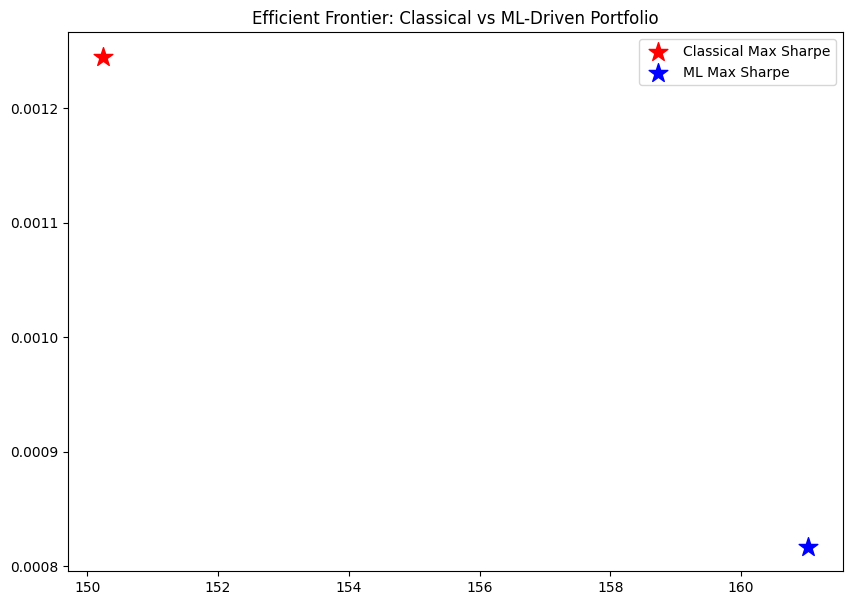

In [29]:
plt.figure(figsize=(10,7))
# plotting.plot_efficient_frontier(ef_classical, show_assets=True)

# Mark classical max Sharpe
ret_c, vol_c, sharpe_c = performance_classical
plt.scatter(vol_c, ret_c, marker="*", color="red", s=200, label="Classical Max Sharpe")

# Mark ML max Sharpe
ret_ml, vol_ml, sharpe_ml = performance_ml
plt.scatter(vol_ml, ret_ml, marker="*", color="blue", s=200, label="ML Max Sharpe")

plt.title("Efficient Frontier: Classical vs ML-Driven Portfolio")
plt.legend()
plt.show()

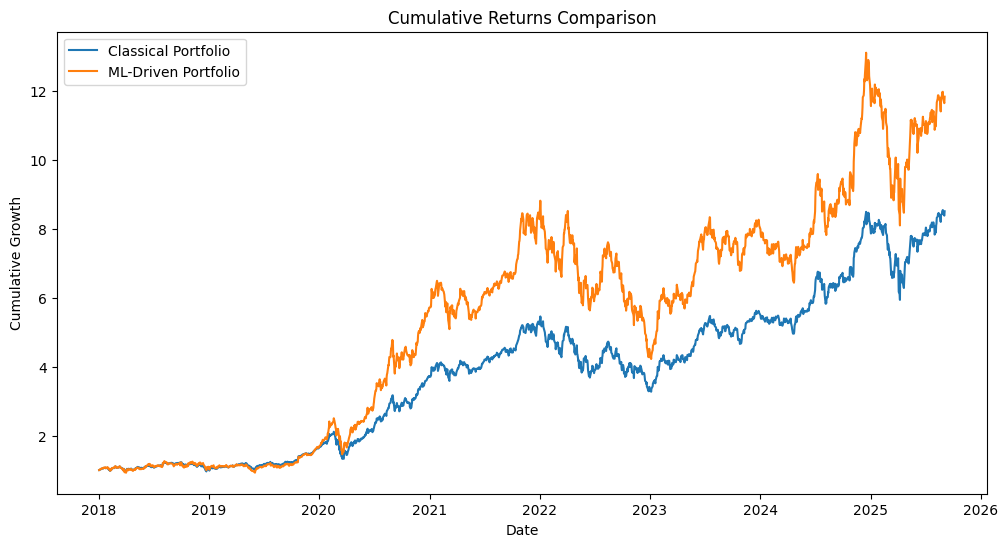

In [30]:
# Portfolio backtest - Cumulative Returns

# Compute daily portfolio returns for both strategies
w_classical = pd.Series(cleaned_weights_classical)
w_ml = pd.Series(cleaned_weights_ml)

port_ret_classical = (returns * w_classical).sum(axis=1)
port_ret_ml = (returns * w_ml).sum(axis=1)

cum_ret_classical = (1 + port_ret_classical).cumprod()
cum_ret_ml = (1 + port_ret_ml).cumprod()

plt.figure(figsize=(12,6))
plt.plot(cum_ret_classical, label="Classical Portfolio")
plt.plot(cum_ret_ml, label="ML-Driven Portfolio")
plt.title("Cumulative Returns Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth")
plt.legend()
plt.show()